# Hepatic clearance model
Simple example model for coupling to sinusoidal and PKPD model structure.
Detoxification of substance `S` via hepatic transformation to `P`.

['time', '[S_ext]', '[S]', '[P]', '[P_ext]']


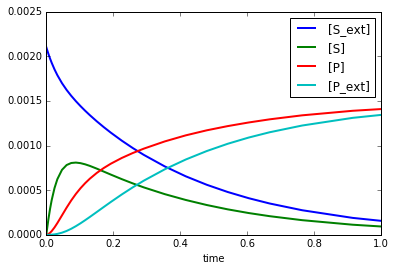

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

In [2]:
# simulation to steady state
%matplotlib inline
from __future__ import print_function, division
import tellurium as te
from matplotlib import pyplot as plt
import clearance
r = te.loads(clearance.sbml_path)
r.integrator.absolute_tolerance = 1E-20
r.integrator.variable_step_size = True

# print(r.getAntimony(current=False))
r.resetToOrigin()
s = r.simulate(0,1)
print(r.selections)
r.plot(s)

## Time dependent challenge
Challenging the model with different external concentrations.

The external model has a fixed volume without any boundary conditions so that the model runs into a steady state.

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

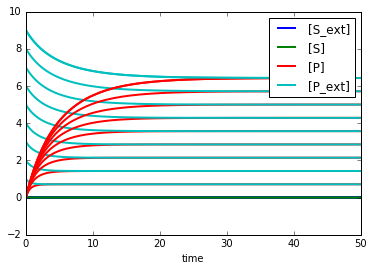

In [6]:
# give a time dependent challenge via composition of models
for k in range(10):
    r.reset()
    r['init([P_ext])'] = k
    s = r.simulate(0, 50)
    r.plot(s, show=False, loc=False)
r.plot(s, show=False)

Internal and external concentrations reach equilibrium.

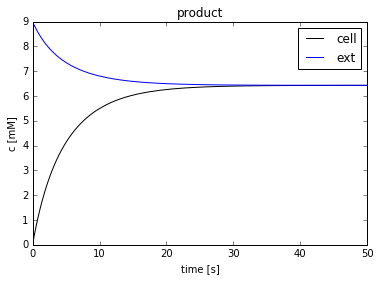

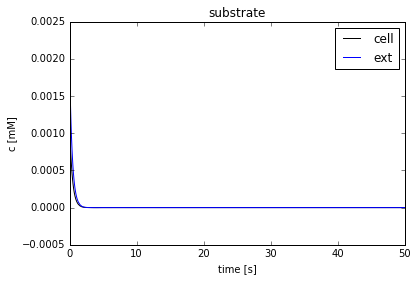

In [7]:
for key, name in {'P': 'product', 
                  'S': 'substrate'}.iteritems():
    plt.plot(s['time'], s['[{}]'.format(key)], color='black', label='cell')
    plt.plot(s['time'], s['[{}_ext]'.format(key)], color='blue', label='ext')
    plt.title(name)
    plt.xlabel('time [s]')
    plt.ylabel('c [mM]')
    
    plt.legend()
    plt.show()


## Parameter variation
Varying of paramters to check model

In [10]:
import multiscale.simulate.roadrunner_tools as rt

# Uset the filepath from the database
r = rt.MyRunner(clearance.sbml_path)
r.timeCourseSelections = ['time'] + ['[{}]'.format(s) for s in r.model.getFloatingSpeciesIds()]
r.set_integrator_settings()

print(r.timeCourseSelections)

Time<__init__> SBML compile: 0.0321118831635 [s]
['time', '[S_ext]', '[S]', '[P]', '[P_ext]']


In [9]:
# These are the parameters to vary
parameter_ids = r.model.getGlobalParameterIds()
r.model.
sorted(parameter_ids)

['A_m',
 'PT_Vmax',
 'PT_k_P',
 'PT_keq',
 'S2P_Vmax',
 'S2P_k_S',
 'ST_Vmax',
 'ST_k_S',
 'ST_keq',
 'Vol_c',
 'Vol_e',
 'Vol_h',
 'f_cl',
 'f_cyto',
 'f_met',
 'f_tissue',
 'x_cell',
 'y_cell']

Time<simulate> : 0.00338697433472 [s]
Time<simulate> : 0.0034008026123 [s]
Time<simulate> : 0.00340890884399 [s]
Time<simulate> : 0.00333595275879 [s]
Time<simulate> : 0.00335812568665 [s]
Time<simulate> : 0.00330090522766 [s]
Time<simulate> : 0.00346493721008 [s]
Time<simulate> : 0.00334501266479 [s]
Time<simulate> : 0.00330686569214 [s]
Time<simulate> : 0.00334715843201 [s]
Time<simulate> : 0.00350213050842 [s]
Time<simulate> : 0.00343489646912 [s]
Time<simulate> : 0.00357604026794 [s]
Time<simulate> : 0.00342011451721 [s]
Time<simulate> : 0.00327301025391 [s]
Time<simulate> : 0.0034008026123 [s]
Time<simulate> : 0.00348806381226 [s]
RuntimeError CVODE integration for pid: f_cl = 0.9*p(0)
could not set value for f_cl, it is defined by an assignment rule, can not be set independently., at int rrllvm::LLVMExecutableModel::setValues(bool (*)(rrllvm::LLVMModelData*, int, double), rrllvm::LLVMExecutableModel::GetNameFuncPtr, int, const int*, const double*)
Time<simulate> : 0.0034561157226

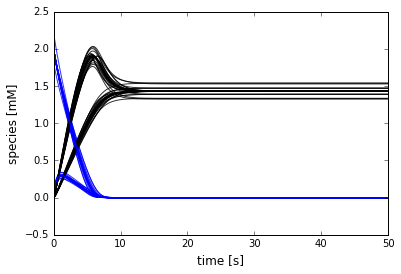

In [21]:
# single parameter variation
plt_fontsize=12
for factor in [0.9, 1.1]:
    for pid in parameter_ids:
        r.resetToOrigin()
        r['[S_ext]'] = 2.0  # [mM]
        try:
            r['{}'.format(pid)] = factor * r['{}'.format(pid)]
            data = r.simulate(0,50)
            plt.plot(data['time'], data['[P]'], '-', color='black', alpha=0.8)
            plt.plot(data['time'], data['[P_ext]'], '-', color='black', alpha=0.8)
            plt.plot(data['time'], data['[S]'], '-', color='blue', alpha=0.8)
            plt.plot(data['time'], data['[S_ext]'], '-', color='blue', alpha=0.8)
        except RuntimeError as detail:
            print("RuntimeError CVODE integration for pid: {} = {}*p(0)\n{}".format(pid, factor, detail))
            
plt.xlabel('time [s]', fontsize=plt_fontsize)
plt.ylabel('species [mM]', fontsize=plt_fontsize);